In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
import sys
sys.path.append('../scripts')
from prediction import *
warnings.filterwarnings('ignore')

In [38]:
store_path = '../datasets/store.csv'
train_path = '../datasets/train.csv'
test_path = '../datasets/test.csv'

# Load datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
store = pd.read_csv(store_path)

# Merge store information into train and test
train_df = train.merge(store, on='Store', how='left')
test_df = test.merge(store, on='Store', how='left')

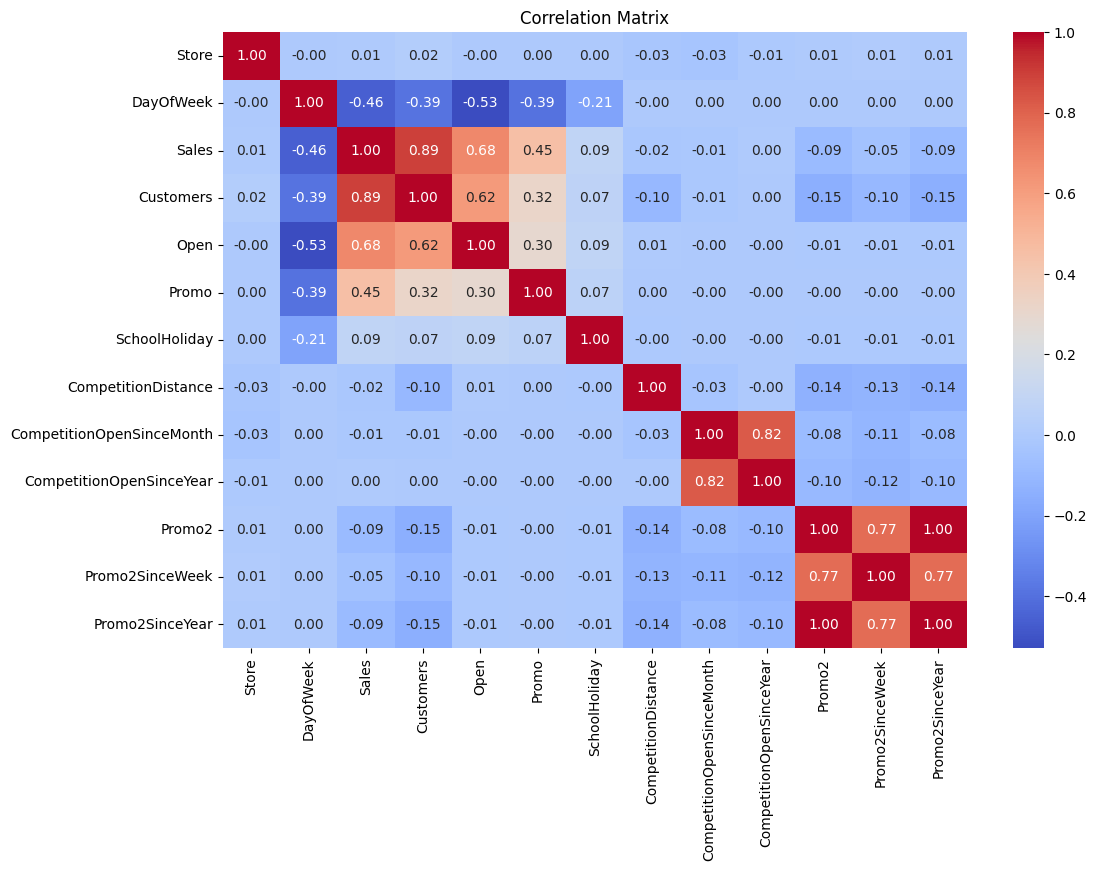

In [71]:
# Calculate correlation matrix
correlation_matrix = train_df.drop(['Date', 'PromoInterval', 'StoreType', 'Assortment', 'StateHoliday'], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [40]:
# Handle missing values
# CompetitionDistance
train_df['CompetitionDistance'].fillna(train_df['CompetitionDistance'].mean(), inplace=True)
test_df['CompetitionDistance'].fillna(test_df['CompetitionDistance'].mean(), inplace=True)
# CompetitionOpenSinceMonth
train_df['CompetitionOpenSinceMonth'].fillna(-1, inplace=True)
test_df['CompetitionOpenSinceMonth'].fillna(-1, inplace=True)
# CompetitionOpenSinceYear
train_df['CompetitionOpenSinceYear'].fillna(-1, inplace=True)
test_df['CompetitionOpenSinceYear'].fillna(-1, inplace=True)
# Promo2SinceWeek
train_df['Promo2SinceWeek'].fillna(-1, inplace=True)
test_df['Promo2SinceWeek'].fillna(-1, inplace=True)
# Promo2SinceYear
train_df['Promo2SinceYear'].fillna(-1, inplace=True)
test_df['Promo2SinceYear'].fillna(-1, inplace=True)
# PromoInterval
train_df['PromoInterval'].fillna('Missing', inplace=True)
test_df['PromoInterval'].fillna('Missing', inplace=True)

In [73]:
features = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

X_train = train_df[features]
y_train = train_df['Sales']  # Target variable

In [74]:
features = ['Store', 'DayOfWeek', 'Open', 'Promo',
       'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

X_test = test_df[features]

In [82]:
categorical_features = ['StoreType', 'Assortment', 'PromoInterval']
numerical_features = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear']

# Define the preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical features
    ],
    remainder='passthrough'  # Keep numerical features as is
)

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess data
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest model
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

In [ ]:
model = pipeline.named_steps['model']  # Extract the RandomForest model from the pipeline
preprocessor = pipeline.named_steps['preprocessor']  # Preprocessing steps

# Predict on the test set
y_pred = pipeline.predict(X_test)

In [ ]:

# 1. Calculate loss
loss = calculate_loss(y_test, y_pred)
print(f"Mean Squared Error: {loss}")

Training RMSE: 145812.17908007998


In [8]:

# 2. Feature importance
# For feature importance, we need the column names from the OneHotEncoder output
feature_names = preprocessor.transformers_[0][1].get_feature_names_out(input_features=categorical_features)
all_feature_names = list(feature_names) + numerical_features  # Combine numerical features
importance_df = feature_importance(model, all_feature_names)
print("Feature Importance:\n", importance_df)

In [ ]:

# 3. Confidence interval
lower_bound, upper_bound = confidence_interval(y_pred)
print(f"95% Confidence Interval: ({lower_bound}, {upper_bound})")

In [ ]:

# 4. Serialize the model and scaler
serialize_model(model, preprocessor, filename="random_forest_model", path="models")